In [1]:
!cp -rp ../input/nvidiaapex/apex-master/* ./

In [2]:
!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

/opt/conda/lib/python3.7/site-packages/pip/_internal/commands/install.py:243: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
Non-user install because site-packages writeable
Created temporary directory: /tmp/pip-ephem-wheel-cache-_vzcj1xc
Created temporary directory: /tmp/pip-req-tracker-qd7d1wge
Initialized build tracking at /tmp/pip-req-tracker-qd7d1wge
Created build tracker: /tmp/pip-req-tracker-qd7d1wge
Entered build tracker: /tmp/pip-req-tracker-qd7d1wge
Created temporary directory: /tmp/pip-install-v7tkasb5
Processing /kaggle/working
  Added file:///kaggle/working to build tracker '/tmp/pip-req-tracker-qd7d1wge'
    Running setup.py (path:/kaggle/working/setup.py) egg_info for package from file:///kaggle/working
    Created temporary directory: /tmp/pip-pip-egg-info-eeakyg3p
    Running command python setup.py egg_info


    torch.__version__  = 1.5.0


    running eg

In [3]:
!pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null

In [4]:
import sys
sys.path.insert(0, "../input/timm-efficientdet-pytorch")
sys.path.insert(0, "../input/omegaconf")
sys.path.insert(0, "../input/weightedboxesfusion")

from ensemble_boxes import *
import torch
import numpy as np
import pandas as pd
from glob import glob
import random
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from datetime import datetime
import time
import cv2
import gc
import os
from matplotlib import pyplot as plt
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain,DetBenchEval
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from sklearn.model_selection import StratifiedKFold, train_test_split
from effdet.efficientdet import HeadNet
import effdet.anchors as anchors
from timm.scheduler import CosineLRScheduler
import math
from copy import deepcopy
from apex import amp
import torch.nn as nn

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [5]:
trained_weight_path = '../input/efficidentdet7fullsize/best-checkpoint-054epoch.bin'

## TTA + Create Pseudo label

In [6]:
class BaseWheatTTA:
    """ author: @shonenkov """
    image_size = 1024

    def augment(self, image):
        raise NotImplementedError
    
    def batch_augment(self, images):
        raise NotImplementedError
    
    def deaugment_boxes(self, boxes):
        raise NotImplementedError

class TTAHorizontalFlip(BaseWheatTTA):
    """ author: @shonenkov """

    def augment(self, image):
        return image.flip(1)
    
    def batch_augment(self, images):
        return images.flip(2)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [1,3]] = self.image_size - boxes[:, [3,1]]
        return boxes

class TTAVerticalFlip(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return image.flip(2)
    
    def batch_augment(self, images):
        return images.flip(3)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,2]] = self.image_size - boxes[:, [2,0]]
        return boxes
    
class TTARotate90(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 1, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 1, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = self.image_size - boxes[:, [1,3]]
        res_boxes[:, [1,3]] = boxes[:, [2,0]]
        return res_boxes

class TTACompose(BaseWheatTTA):
    """ author: @shonenkov """
    def __init__(self, transforms):
        self.transforms = transforms
        
    def augment(self, image):
        for transform in self.transforms:
            image = transform.augment(image)
        return image
    
    def batch_augment(self, images):
        for transform in self.transforms:
            images = transform.batch_augment(images)
        return images
    
    def prepare_boxes(self, boxes):
        result_boxes = boxes.copy()
        result_boxes[:,0] = np.min(boxes[:, [0,2]], axis=1)
        result_boxes[:,2] = np.max(boxes[:, [0,2]], axis=1)
        result_boxes[:,1] = np.min(boxes[:, [1,3]], axis=1)
        result_boxes[:,3] = np.max(boxes[:, [1,3]], axis=1)
        return result_boxes
    
    def deaugment_boxes(self, boxes):
        for transform in self.transforms[::-1]:
            boxes = transform.deaugment_boxes(boxes)
        return self.prepare_boxes(boxes)

In [7]:
from itertools import product

tta_transforms = []
for tta_combination in product([TTAHorizontalFlip(), None], 
                               [TTAVerticalFlip(), None],
                               [TTARotate90(), None]):
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))

In [8]:
def make_tta_predictions(images, nets, score_threshold=0.25):
    all_predictions = []
    images = torch.stack(images).float().cuda()
    for fold_num, net in enumerate(nets):
        with torch.no_grad():
            predictions = []
            for tta_transform in tta_transforms:
                result = []
                det = net(tta_transform.batch_augment(images.clone()), torch.tensor([1]*images.shape[0]).float().cuda())

                for i in range(images.shape[0]):
                    boxes = det[i].detach().cpu().numpy()[:,:4]    
                    scores = det[i].detach().cpu().numpy()[:,4]
                    indexes = np.where(scores > score_threshold)[0]
                    boxes = boxes[indexes]
                    boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                    boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
                    boxes = tta_transform.deaugment_boxes(boxes.copy())
                    result.append({
                        'boxes': boxes,
                        'scores': scores[indexes],
                    })
                predictions.append(result)
            all_predictions.append(predictions)
            
    return all_predictions

def run_wbf(all_predictions, image_index, image_size=1024, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    for i in range(len(nets)):
        predictions = all_predictions[i]
        if i == 0:
            boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist()  for prediction in predictions]
            scores = [prediction[image_index]['scores'].tolist()  for prediction in predictions]
            labels = [np.ones(prediction[image_index]['scores'].shape[0]).tolist() for prediction in predictions]
        else:
            boxes += [(prediction[image_index]['boxes']/(image_size-1)).tolist()  for prediction in predictions]
            scores += [prediction[image_index]['scores'].tolist()  for prediction in predictions]
            labels += [np.ones(prediction[image_index]['scores'].shape[0]).tolist() for prediction in predictions]
            
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

In [9]:
def create_model_efficientdet_test(compound_coef:int, weight_path=None,
                              num_classes=1, image_size=1024, pretrained=False, model_ema=False):

    config = get_efficientdet_config(f'tf_efficientdet_d{compound_coef}')
    model = EfficientDet(config, pretrained_backbone=pretrained)
    config.num_classes = num_classes
    config.image_size = image_size
    model.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    
    checkpoint = torch.load(weight_path)
    #ck = fix_model_state_dict(checkpoint['state_dict_ema'])
    if model_ema:
        model.load_state_dict(checkpoint['state_dict_ema'])
    else:
        model.load_state_dict(checkpoint['model_state_dict'])

    
    del checkpoint
    gc.collect()

    model = DetBenchEval(model, config)
    anchors.MAX_DETECTIONS_PER_IMAGE=250
    model.eval();
    
    return model.cuda()


nets = [create_model_efficientdet_test(compound_coef=4, 
                                  weight_path='../input/efficidentdet4-fullsize/best-checkpoint-058epoch.bin', 
                                  pretrained=False,
                                  model_ema=True),
        create_model_efficientdet_test(compound_coef=5, 
                                 weight_path='../input/efficientdet5-fullsize/best-checkpoint-052epoch.bin', 
                                 pretrained=False),
        create_model_efficientdet_test(compound_coef=7, 
                                weight_path=trained_weight_path, 
                                pretrained=False,
                                model_ema=True)]
#before_pesudo_label_net = create_model_efficientdet_test(compound_coef=7, 
                                #weight_path=trained_weight_path, 
                                #pretrained=False,
                                #model_ema=True)

In [10]:
def get_test_transforms():
    return A.Compose([
            A.Resize(height=1024, width=1024, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [11]:
DATA_ROOT_PATH = '../input/global-wheat-detection/test'

class DatasetRetrieverTest(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [12]:
test_dataset = DatasetRetrieverTest(
    image_ids=np.array([path.split('/')[-1][:-4] for path in glob(f'{DATA_ROOT_PATH}/*.jpg')]),
    transforms=get_test_transforms()
)

def collate_fn(batch):
    return tuple(zip(*batch))

test_data_loader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [13]:
def predict_test(data_loader,nets):
    results = []
    testdf_psuedo = []

    for images, image_ids in data_loader:
        predictions = make_tta_predictions(images=images, nets=nets)
        for i, image in enumerate(images):
            boxes, scores, labels = run_wbf(predictions, image_index=i)
            boxes = boxes.astype(np.int32).clip(min=0, max=1023)
            image_id = image_ids[i]

            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

            for box in boxes:
                result = {
                    'image_id': image_id,
                    'source': 'BULLBULL',
                    'width':1024,
                    'height':1024,
                    'x': box[0],
                    'y': box[1],
                    'w': box[2],
                    'h': box[3]        
                }
                testdf_psuedo.append(result)

    test_df_pseudo = pd.DataFrame(testdf_psuedo, columns=['image_id', 'width', 'height', 'source', 'x', 'y', 'w', 'h'])
    return test_df_pseudo

In [14]:
test_df_pseudo = predict_test(test_data_loader, nets)

/opt/conda/conda-bld/pytorch_1587428398394/work/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


In [15]:
test_df_pseudo.head()

,image_id,width,height,source,x,y,w,h
0,cc3532ff6,1024,1024,BULLBULL,770,828,166,162
1,cc3532ff6,1024,1024,BULLBULL,74,800,139,176
2,cc3532ff6,1024,1024,BULLBULL,909,123,112,97
3,cc3532ff6,1024,1024,BULLBULL,264,640,101,168
4,cc3532ff6,1024,1024,BULLBULL,553,829,126,176


## Create Training Data

In [16]:
def generate_train(test_df_pseudo, fold_=1):
    print("Loading training set...")
    marking = pd.read_csv('../input/wheat-cleaned-dataset/clean_train_v2.csv')
    marking = marking[marking['area']> 300]
    df_with_pseudo = pd.concat([marking, test_df_pseudo])

    index = list(set(marking.image_id))
    fold = 0
    val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
    train_index = index[:len(index)*fold//5] + index[len(index)*(fold+1)//5:]

    train_df_pseudo_fold = test_df_pseudo['image_id'].unique()

    train_fold = np.concatenate((train_index, train_df_pseudo_fold))
    print('train dataset size:', len(train_fold))

    
    val_fold = np.array(val_index)
    print('val dataset size:', len(val_fold))
    
    return df_with_pseudo, train_fold, val_fold

In [17]:
df_with_pesudo, train_fold, val_fold = generate_train(test_df_pseudo)

Loading training set...
train dataset size: 2709
val dataset size: 674


## Training

In [18]:
def get_train_transforms():
    return A.Compose(
        [
            #A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            
            A.Resize(height=1024, width=1024, p=1),
            #A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=1024, width=1024, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [19]:
def randomsizedCroped(image, boxes, min_max_height=(800, 800), height=1024, width=1024, w2h_ratio=1.0):
    """
    https://github.com/albumentations-team/albumentations/
    """
    crop_height = random.randint(min_max_height[0], min_max_height[1])
    h_start = random.random()
    w_start = random.random()
    crop_width = int(crop_height * w2h_ratio)
    image_ = image.copy()
    boxes_ = boxes.copy()

    def get_random_crop_coords(height, width, crop_height, crop_width, h_start, w_start):
        y1 = int((height - crop_height) * h_start)
        y2 = y1 + crop_height
        x1 = int((width - crop_width) * w_start)
        x2 = x1 + crop_width
        return x1, y1, x2, y2

    x1, y1, x2, y2 = get_random_crop_coords(height, width, crop_height, crop_width, h_start, w_start)
    image_ = image_[y1:y2, x1:x2]
    image_ = cv2.resize(image_, (height, width))

    ratio = [width / crop_width, height / crop_height]
    # shift box
    boxes_[:, 0] = boxes_[:, 0] - x1
    boxes_[:, 1] = boxes_[:, 1] - y1
    boxes_[:, 2] = boxes_[:, 2] - x1
    boxes_[:, 3] = boxes_[:, 3] - y1

    # resize box
    boxes_[:, 0] = ratio[0] * boxes_[:, 0]
    boxes_[:, 1] = ratio[1] * boxes_[:, 1]
    boxes_[:, 2] = ratio[0] * boxes_[:, 2]
    boxes_[:, 3] = ratio[1] * boxes_[:, 3]
    boxes_[:, [0, 2]] = boxes_[:, [0, 2]].clip(min=0, max=width - 1)
    boxes_[:, [1, 3]] = boxes_[:, [1, 3]].clip(min=0, max=height - 1)

    boxes_ = boxes_.astype(np.int32)
    boxes_ = boxes_[np.where((boxes_[:, 2] - boxes_[:, 0]) * (boxes_[:, 3] - boxes_[:, 1]) > 0.0)]

    if len(boxes_) == 0:
        return image, boxes
    else:
        return image_, boxes_

In [20]:
def cutout(image, labels):
    # https://arxiv.org/abs/1708.04552
    # https://github.com/hysts/pytorch_cutout/blob/master/dataloader.py
    # https://towardsdatascience.com/when-conventional-wisdom-fails-revisiting-data-augmentation-for-self-driving-cars-4831998c5509
    # https://github.com/ultralytics/yolov5/blob/master/utils/datasets.py
    h, w = image.shape[:2]
    image_copy = image.copy()
    labels_copy = labels.copy()

    def bbox_ioa(box1, box2):
        # Returns the intersection over box2 area given box1, box2. box1 is 4, box2 is nx4. boxes are x1y1x2y2
        box2 = box2.transpose()

        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[0], box1[1], box1[2], box1[3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[0], box2[1], box2[2], box2[3]

        # Intersection area
        inter_area = (np.minimum(b1_x2, b2_x2) - np.maximum(b1_x1, b2_x1)).clip(0) * \
                     (np.minimum(b1_y2, b2_y2) - np.maximum(b1_y1, b2_y1)).clip(0)

        # box2 area
        box2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1) + 1e-16

        # Intersection over box2 area
        return inter_area / box2_area

    # create random masks
    scales = [0.125] * 8 + [0.0625] * 12 + [0.03125] * 16 # image size fraction
    for s in scales:
        y = random.randint(0, h)
        x = random.randint(0, w)

        y1 = np.clip(y - h*s // 2, 0, h)
        y2 = np.clip(y1 + h*s, 0, h)
        x1 = np.clip(x - w*s // 2, 0, w)
        x2 = np.clip(x1 + w*s, 0, w)

        # apply random color mask
        image[int(y1):int(y2), int(x1):int(x2)] = 0

        # return unobscured labels
        if len(labels) and s > 0.03:
            box = np.array([x1, y1, x2, y2], dtype=np.float32)
            ioa = bbox_ioa(box, labels[:, 0:4])  # intersection over area
            labels = labels[ioa < 0.60]  # remove >60% obscured labels

    if len(labels) == 0:
        return image_copy, labels_copy

    return image, labels

In [21]:
def random_affine(img, targets=(), degrees=0, translate=0, scale=0.5, shear=0, border=[-1024 // 2, -1024 // 2]):
    # torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(.1, .1), scale=(.9, 1.1), shear=(-10, 10))
    # https://medium.com/uruvideo/dataset-augmentation-with-random-homographies-a8f4b44830d4
    
    if targets is None:  # targets = [cls, xyxy]
        targets = []
    
    img_, target_ = img.copy(), targets.copy()
    
    height = img.shape[0] + border[0] * 2  # shape(h,w,c)
    width = img.shape[1] + border[1] * 2

    # Rotation and Scale
    R = np.eye(3)
    a = random.uniform(-degrees, degrees)
    # a += random.choice([-180, -90, 0, 90])  # add 90deg rotations to small rotations
    s = random.uniform(1 - scale, 1 + scale)
    # s = 2 ** random.uniform(-scale, scale)
    R[:2] = cv2.getRotationMatrix2D(angle=a, center=(img.shape[1] / 2, img.shape[0] / 2), scale=s)

    # Translation
    T = np.eye(3)
    T[0, 2] = random.uniform(-translate, translate) * img.shape[1] + border[1]  # x translation (pixels)
    T[1, 2] = random.uniform(-translate, translate) * img.shape[0] + border[0]  # y translation (pixels)

    # Shear
    S = np.eye(3)
    S[0, 1] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # x shear (deg)
    S[1, 0] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # y shear (deg)

    # Combined rotation matrix
    M = S @ T @ R  # ORDER IS IMPORTANT HERE!!
    if (border[0] != 0) or (border[1] != 0) or (M != np.eye(3)).any():  # image changed
        img = cv2.warpAffine(img, M[:2], dsize=(width, height), flags=cv2.INTER_LINEAR, 
                             borderValue=(114/255, 114/255, 114/255))

    # Transform label coordinates
    n = len(targets)
    if n:
        # warp points
        xy = np.ones((n * 4, 3))
        xy[:, :2] = targets[:, [0, 1, 2, 3, 0, 3, 2, 1]].reshape(n * 4, 2)  # x1y1, x2y2, x1y2, x2y1
        xy = (xy @ M.T)[:, :2].reshape(n, 8)

        # create new boxes
        x = xy[:, [0, 2, 4, 6]]
        y = xy[:, [1, 3, 5, 7]]
        xy = np.concatenate((x.min(1), y.min(1), x.max(1), y.max(1))).reshape(4, n).T

        # # apply angle-based reduction of bounding boxes
        # radians = a * math.pi / 180
        # reduction = max(abs(math.sin(radians)), abs(math.cos(radians))) ** 0.5
        # x = (xy[:, 2] + xy[:, 0]) / 2
        # y = (xy[:, 3] + xy[:, 1]) / 2
        # w = (xy[:, 2] - xy[:, 0]) * reduction
        # h = (xy[:, 3] - xy[:, 1]) * reduction
        # xy = np.concatenate((x - w / 2, y - h / 2, x + w / 2, y + h / 2)).reshape(4, n).T

        # reject warped points outside of image
        xy[:, [0, 2]] = xy[:, [0, 2]].clip(0, width)
        xy[:, [1, 3]] = xy[:, [1, 3]].clip(0, height)
        w = xy[:, 2] - xy[:, 0]
        h = xy[:, 3] - xy[:, 1]
        area = w * h
        area0 = (targets[:, 2] - targets[:, 0]) * (targets[:, 3] - targets[:, 1])
        ar = np.maximum(w / (h + 1e-16), h / (w + 1e-16))  # aspect ratio
        i = (w > 4) & (h > 4) & (area / (area0 * s + 1e-16) > 0.2) & (ar < 10)

        targets = targets[i]
        targets[:, 0:4] = xy[i]
    
    if len(targets) == 0:
        return img_, target_
    
    return img, targets

In [22]:
TRAIN_ROOT_PATH = '../input/global-wheat-detection/train'

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False, mixup=True):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test
        self.mixup = mixup
        self.mosaic_border = [-1024//2, -1024//2]

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        origin_image = False
        if self.test or random.random() > 0.5:
            image, boxes = self.load_image_and_boxes(index)
            origin_image = True
        else:
            image, boxes = self.load_cutmix_image_and_boxes(index)
            
        #if self.mixup and origin_image == True and (random.random() > 0.5) and (self.test == False):
            #random_index = random.choice(np.delete(np.arange(self.image_ids.shape[0]), index))
            #mix_image, mix_boxes = self.load_image_and_boxes(random_index)
            #factor = 0.5
            #image = factor*image + (1-factor)*mix_image
            #boxes = np.concatenate([boxes, mix_boxes], 0)
        #if (random.random() < 0.5) and (self.test == False):
            #image, boxes = randomsizedCroped(image, boxes)               
        if (random.random() < 0.9) and (self.test == False):
            image, boxes = cutout(image, boxes)

        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['labels'] = torch.ones((len(sample['bboxes']),), dtype=torch.int64)
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        if os.path.exists(f'{TRAIN_ROOT_PATH}/{image_id}.jpg'):
            image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        else:
            image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR) 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image = cv2.resize(image, (1024, 1024))
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes

    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize

        xc, yc = [int(random.uniform(-x, 2 * s + x)) for x in self.mosaic_border]
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize*2, imsize*2, 3), 114/255, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:, 2] - result_boxes[:, 0]) * (result_boxes[:, 3] - result_boxes[:, 1]) > 300.0)]
        result_boxes = result_boxes[np.where((result_boxes[:, 2] - result_boxes[:, 0]) >= 10.0)]
        result_boxes = result_boxes[np.where((result_boxes[:, 3] - result_boxes[:, 1]) >= 10.0)]
        result_image, result_boxes = random_affine(result_image, targets=result_boxes)

        return result_image, result_boxes

In [23]:
train_dataset = DatasetRetriever(
    image_ids=train_fold,
    marking=df_with_pesudo,
    transforms=get_train_transforms(),
    test=False,
)

validation_dataset = DatasetRetriever(
    image_ids=val_fold,
    marking=df_with_pesudo,
    transforms=get_valid_transforms(),
    test=True,
)

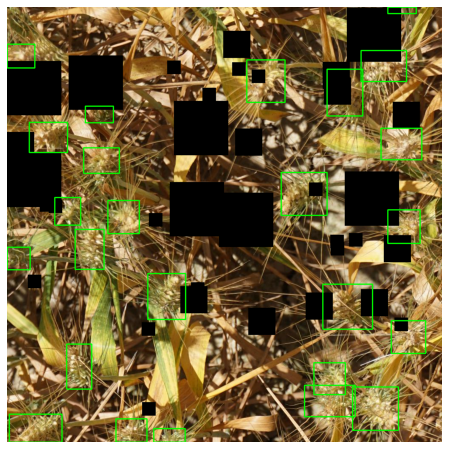

In [24]:
image, target, image_id = train_dataset[0]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

In [25]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [26]:
class TrainGlobalConfig:
    num_workers = 2
    batch_size = 2
    use_amp = True #use nvidia apex
    use_ema = True #use model ema
    n_epochs = 8
    total_batch_size = 8
    clip_grad = True
    accumulate_steps = int(total_batch_size / batch_size) #real batch_size = 16, 
    lr = 0.0035
    folder = 'effdet7'

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss

    SchedulerClass = CosineLRScheduler
    scheduler_params = dict(
        t_initial=n_epochs, 
        t_mul=1.0, 
        lr_min = 1e-8,
    )
    # --------------------

In [27]:
def is_parallel(model):
    # is model is parallel with DP or DDP
    return type(model) in (nn.parallel.DataParallel, nn.parallel.DistributedDataParallel)

class ModelEMA:
    """ Model Exponential Moving Average from https://github.com/rwightman/pytorch-image-models
    Keep a moving average of everything in the model state_dict (parameters and buffers).
    This is intended to allow functionality like
    https://www.tensorflow.org/api_docs/python/tf/train/ExponentialMovingAverage
    A smoothed version of the weights is necessary for some training schemes to perform well.
    This class is sensitive where it is initialized in the sequence of model init,
    GPU assignment and distributed training wrappers.
    """

    def __init__(self, model, decay=0.9999, updates=0):
        # Create EMA
        self.ema = deepcopy(model.module if is_parallel(model) else model).eval()  # FP32 EMA
        # if next(model.parameters()).device.type != 'cpu':
        #     self.ema.half()  # FP16 EMA
        self.updates = updates  # number of EMA updates
        self.decay = lambda x: decay * (1 - math.exp(-x / 2000))  # decay exponential ramp (to help early epochs)
        for p in self.ema.parameters():
            p.requires_grad_(False)

    def update(self, model):
        # Update EMA parameters
        with torch.no_grad():
            self.updates += 1
            d = self.decay(self.updates)

            msd = model.module.state_dict() if is_parallel(model) else model.state_dict()  # model state_dict
            for k, v in self.ema.state_dict().items():
                if v.dtype.is_floating_point:
                    v *= d
                    v += (1. - d) * msd[k].detach()

    def update_attr(self, model, include=(), exclude=('process_group', 'reducer')):
        # Update EMA attributes
        copy_attr(self.ema, model, include, exclude)

In [28]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5
        
        self.model = model
        self.device = device
        self.use_amp = config.use_amp
        self.accumulate_steps = config.accumulate_steps
        self.clip_grad = config.clip_grad
        self.max_norm = 10.0
        self.use_ema = config.use_ema
        self.model_ema = None
        self.model_ema_decay = 0.999
        
        pg0, pg1, pg2 = [], [], []  # optimizer parameter groups
        for k, v in self.model.named_parameters():
            if v.requires_grad:
                if '.bias' in k:
                    pg2.append(v)  # biases
                elif '.weight' in k and '.bn' not in k:
                    pg1.append(v)  # apply weight decay
                else:
                    pg0.append(v)  # all else
        self.optimizer = torch.optim.SGD(pg0, lr=config.lr, momentum=0.9, nesterov=True)
        self.optimizer.add_param_group({'params': pg1, 'weight_decay': 5e-4})
        self.optimizer.add_param_group({'params': pg2})  
        
        self.model.to(self.device)
        
        if self.use_amp:
            self.model, self.optimizer = amp.initialize(self.model, self.optimizer, opt_level="O1",verbosity=0)
        if self.use_ema:
            self.model_ema = ModelEMA(self.model, decay=self.model_ema_decay)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        
        best_epoch = 0
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            if self.use_ema:
                summary_loss = self.validation(self.model_ema.ema.module if hasattr(self.model_ema.ema, 'module') else self.model_ema.ema, 
                                               validation_loader)
            else:
                summary_loss = self.validation(self.model, validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)
                best_epoch = e

            if self.config.validation_scheduler:
                self.scheduler.step(e+1)

            self.epoch += 1
            
        return best_epoch
            
    def validation(self, model, val_loader):
        model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images).to(self.device).float()
                batch_size = images.shape[0]
                target_input = {'bbox':[target['boxes'].to(self.device).float() for target in targets],
                                'cls': [target['labels'].to(self.device).float() for target in targets]} 
                loss = model(images, target_input['bbox'], target_input['cls'])
                loss, class_loss, box_loss = loss
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        self.optimizer.zero_grad() #very important
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            images = torch.stack(images).to(self.device).float()
            batch_size = images.shape[0]
            target_input = {'bbox':[target['boxes'].to(self.device).float() for target in targets],
                            'cls': [target['labels'].to(self.device).float() for target in targets]} 

            loss = self.model(images, target_input['bbox'], target_input['cls'])
            loss, class_loss, box_loss = loss
            
            if self.use_amp:
                with amp.scale_loss(loss, self.optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            if (step+1) % self.accumulate_steps == 0: # Wait for several backward steps
                if self.clip_grad:
                    if self.use_amp:
                        torch.nn.utils.clip_grad_norm_(amp.master_params(self.optimizer), self.max_norm)
                    else:
                        torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.max_norm)
                
                self.optimizer.step()  # Now we can do an optimizer step
                self.optimizer.zero_grad()
                if self.model_ema is not None:
                    self.model_ema.update(self.model)

            summary_loss.update(loss.detach().item(), batch_size)

            if self.config.step_scheduler:
                self.scheduler.step()

            
        return summary_loss
    
    def save(self, path):
        self.model.eval()
        
        if self.use_ema:
            torch.save({
                'model_state_dict': self.model.model.state_dict(),
                'state_dict_ema': self.model_ema.ema.module.state_dict() if hasattr(self.model_ema.ema, 'module') else self.model_ema.ema.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'scheduler_state_dict': self.scheduler.state_dict(),
                'best_summary_loss': self.best_summary_loss,
                'epoch': self.epoch,
            }, path)
        else:
            torch.save({
                'model_state_dict': self.model.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'scheduler_state_dict': self.scheduler.state_dict(),
                'best_summary_loss': self.best_summary_loss,
                'epoch': self.epoch,
            }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [29]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training():
    device = torch.device('cuda:0')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    best_epoch = fitter.fit(train_loader, val_loader)
    
    return best_epoch

In [30]:
def get_net():
    config = get_efficientdet_config('tf_efficientdet_d7')
    net = EfficientDet(config, pretrained_backbone=False)
    config.num_classes = 1
    config.image_size = 1024
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    
    checkpoint = torch.load(trained_weight_path)
    net.load_state_dict(checkpoint['state_dict_ema'])
    
    return DetBenchTrain(net, config)

net = get_net()

In [31]:
best_epoch = None 
if len(os.listdir("../input/global-wheat-detection/test/")) > 11:
    best_epoch = run_training()

## Inference 

In [32]:
if best_epoch is not None:
    print("load retrained model {}".format(best_epoch))
    net = create_model_efficientdet_test(compound_coef=7, 
                                     weight_path=f'./effdet7/best-checkpoint-{str(best_epoch).zfill(3)}epoch.bin', 
                                     image_size=1024,
                                     model_ema=True)
else:
    net = create_model_efficientdet_test(compound_coef=7, 
                                     weight_path=trained_weight_path, 
                                     image_size=1024,
                                     model_ema=True)

In [33]:
class BaseWheatTTA:
    """ author: @shonenkov """
    image_size = 1024

    def augment(self, image):
        raise NotImplementedError
    
    def batch_augment(self, images):
        raise NotImplementedError
    
    def deaugment_boxes(self, boxes):
        raise NotImplementedError

class TTAHorizontalFlip(BaseWheatTTA):
    """ author: @shonenkov """

    def augment(self, image):
        return image.flip(1)
    
    def batch_augment(self, images):
        return images.flip(2)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [1,3]] = self.image_size - boxes[:, [3,1]]
        return boxes

class TTAVerticalFlip(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return image.flip(2)
    
    def batch_augment(self, images):
        return images.flip(3)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,2]] = self.image_size - boxes[:, [2,0]]
        return boxes
    
class TTARotate90(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 1, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 1, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = self.image_size - boxes[:, [1,3]]
        res_boxes[:, [1,3]] = boxes[:, [2,0]]
        return res_boxes

class TTACompose(BaseWheatTTA):
    """ author: @shonenkov """
    def __init__(self, transforms):
        self.transforms = transforms
        
    def augment(self, image):
        for transform in self.transforms:
            image = transform.augment(image)
        return image
    
    def batch_augment(self, images):
        for transform in self.transforms:
            images = transform.batch_augment(images)
        return images
    
    def prepare_boxes(self, boxes):
        result_boxes = boxes.copy()
        result_boxes[:,0] = np.min(boxes[:, [0,2]], axis=1)
        result_boxes[:,2] = np.max(boxes[:, [0,2]], axis=1)
        result_boxes[:,1] = np.min(boxes[:, [1,3]], axis=1)
        result_boxes[:,3] = np.max(boxes[:, [1,3]], axis=1)
        return result_boxes
    
    def deaugment_boxes(self, boxes):
        for transform in self.transforms[::-1]:
            boxes = transform.deaugment_boxes(boxes)
        return self.prepare_boxes(boxes)

from itertools import product

tta_transforms = []
for tta_combination in product([TTAHorizontalFlip(), None], 
                               [TTAVerticalFlip(), None],
                               [TTARotate90(), None]):
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))

def make_tta_predictions(images, net, score_threshold=0.25):
    with torch.no_grad():
        images = torch.stack(images).float().cuda()
        predictions = []
        for tta_transform in tta_transforms:
            result = []
            det = net(tta_transform.batch_augment(images.clone()), torch.tensor([1]*images.shape[0]).float().cuda())

            for i in range(images.shape[0]):
                boxes = det[i].detach().cpu().numpy()[:,:4]    
                scores = det[i].detach().cpu().numpy()[:,4]
                indexes = np.where(scores > score_threshold)[0]
                boxes = boxes[indexes]
                boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
                boxes = tta_transform.deaugment_boxes(boxes.copy())
                result.append({
                    'boxes': boxes,
                    'scores': scores[indexes],
                })
            predictions.append(result)
    return predictions

def run_wbf(predictions, image_index, image_size=1024, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist() for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist() for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).astype(int).tolist() for prediction in predictions]
    boxes, scores, labels = ensemble_boxes_wbf.weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

In [34]:
def get_test_transforms():
    return A.Compose([
            A.Resize(height=1024, width=1024, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [35]:
test_dataset = DatasetRetrieverTest(
    image_ids=np.array([path.split('/')[-1][:-4] for path in glob(f'{DATA_ROOT_PATH}/*.jpg')]),
    transforms=get_test_transforms()
)

def collate_fn(batch):
    return tuple(zip(*batch))

test_data_loader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

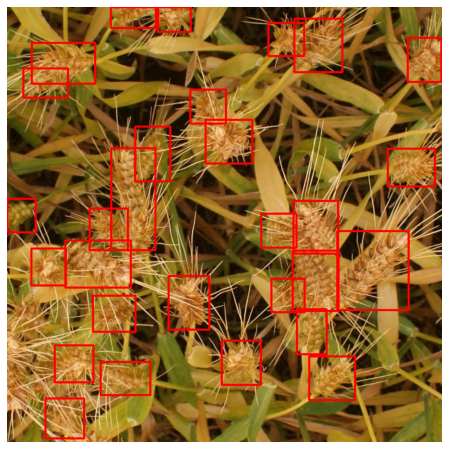

In [36]:
for j, (images, image_ids) in enumerate(test_data_loader):
    break

predictions = make_tta_predictions(images, net=net)

i = 1
sample = images[i].permute(1,2,0).cpu().numpy()

boxes, scores, labels = run_wbf(predictions, image_index=i)
boxes = boxes.astype(np.int32).clip(min=0, max=1023)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample);

In [37]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return " ".join(pred_strings)
results = []

for images, image_ids in test_data_loader:
    predictions = make_tta_predictions(images, net=net)
    for i, image in enumerate(images):
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes = boxes.astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)

In [38]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)
test_df.head()

,image_id,PredictionString
0,cc3532ff6,0.9633 769 827 167 165 0.9058 263 640 102 168 ...
1,796707dd7,0.8851 711 822 108 103 0.8754 896 333 111 89 0...
2,53f253011,0.9159 15 34 144 108 0.8882 620 100 121 146 0....
3,51f1be19e,0.8557 610 85 154 174 0.7812 841 263 131 205 0...
4,f5a1f0358,0.8768 941 432 82 188 0.8575 689 206 112 91 0....
